# Introduction to Python and Napari
## Laura Cooper, CAMDU

The aim of this training is to give you an idea of of what is possible for image analysis with python and napari as well as giving you initial skills and knowledge to begin developing your own scripts.

### SetupCheck

Packages contain of functions and classes. A function performs a task and a classes describes an object. The contents of a package usually relates to a paticular task. For example:
- NumPy is for numerical computing
- Scikit-image is for image analysis
- Napari is for data visualisation
There are many packages available, use an internet search or an AI chatbot to find appropriate packages for your needs.

```%``` indicates a magic command when using IPython (e.g. in Spyder) or Jupyter notebook. In this case it is needed for napari to open. If you are writting a python script (.py), you don't need this line but you will need to use the napari.run() function.

In [1]:
# Gui for rendering
%gui qt5
# Packages
import numpy as np
from skimage.io import imread
import napari

```imread``` is an example of a function. It opens an image file and imports the contents into an array (specifically a numpy array in this case). ```imread``` tries different plugins to open an image, in this case as it is opening a .tif file so it uses the tifffile plugin by default. This means that the ```skimage.io.imread``` command can only read images if it can find an appropriate plugin. To find out more have a look at the [skimage.io.read documentation](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread).

The ```=``` assigns the array to a variable called ```image```. An array is a type of data structure. Data structures are a way to store and organise data. An array has a fixed size and contains elements which are all of the same type. We will look at some examples of types later in the notebook.

In [2]:
# Load image
image = imread("nuclei1_out_c00_dr90_image.tif")

```napari.view_image``` function opens the napari viewer and visualises our ```image```.

In [3]:
# Open image in napari
viewer = napari.view_image(image)

Within napari try:
- Viewing the data in 2D and 3D
- Zooming and rotating
- Changing the rendering settings
- Creating annotations with point and shape layers
- Projecting the image
- View the data in different axes (e.g. x-y, x-z, y-z)

### Investigate image

```image.shape``` tells us the dimensions of ```image```. In this case the order is (ZXY). For images with more dimensions the order may be (ZCTXY) but this can depend on the image or how the file was read in, so it's worth checking if you are getting unexpected results. The syntax ```array.shape``` means we are calling an attribute of the array.
<a id='image.shape'></a>

In [4]:
image.shape

(100, 258, 258)

It's good to know type of image we are working with, e.g. is it 8 bit, 16 bit, RGB, etc. The ```type()``` function tells us variable type and can be used to identify the type of image. We have to call it a single element of the ```image``` array, ```type(image)``` will only tell use that ```image``` is an array. In python indexing starts from 0 so ```image[0,0,0]``` returns the value of the pixel at z=0, x=0, y=0 i.e. the first element from our ```image``` array. Square brackets are used for accessing elements in an array.

The returned value ```numpy.uint16``` means that the elements of a numpy array are "unsigned integer 16-bit". These elements can only store non-negative integer values up to 65535. This tells us we are working with a 16-bit image.

In [5]:
type(image[0,0,0])

numpy.uint16

We can use ```matplotlib.pyplot``` to plot graphs. ```matplotlib``` is the package that can create figures and plots like MATLAB, ```pyplot``` is the module used for creating plots.

In [6]:
import matplotlib.pyplot as plt # Need to install!

Plotting the histogram of the image can help us understand the data. We can use the ```plt.hist()``` function to plot ```image.ravel()``` as a histogram. ```image.ravel()``` converts our image array to a 1D array. ```ravel()``` is a "method"; in python a method is a function associated with an object. In this case, ```ravel()``` is associated with our ```image``` array. It is equivalent to the function ```np.ravel(image)```.

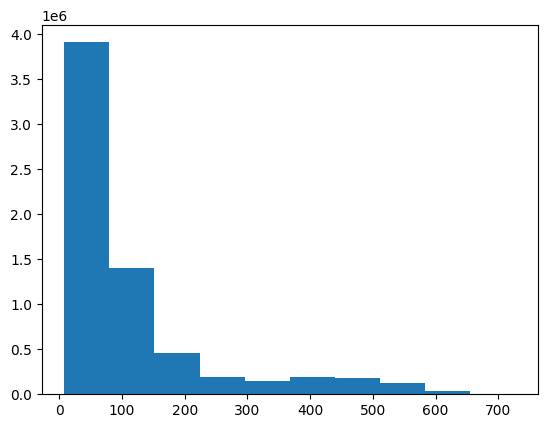

In [7]:
plt.hist(image.ravel())
plt.show()

By default, the ```plt.hist()``` function automatically creates bins for the data. For image data it is more suitable for us to create one bin per intensity value. To do that we pass the ```bins``` parameter to the ```plt.hist``` function, whichs defines the number of bins to plot. Assigning this to be the maximum value for our image results in one bin per intensity value.

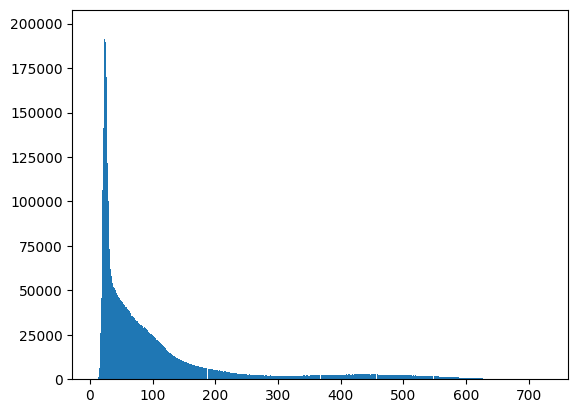

In [8]:
np.max(image)
plt.hist(image.ravel(), bins=np.max(image))
plt.show()

Note that the plot axes are missing. If you'd like to learn how to add these labels and more please see the [matplotlib documentation](https://matplotlib.org/)

### Segmentation

We will segment the image to demonstrate some tools of the ```skimage``` package and how we can use Napari to check our pipeline as we develop it.

To segment the nuclei in the image we will use a threshold. ```skimage.filters``` has a function similar to Fiji's Auto Threshold > Try All. it can be imported from ```skimage.filters```.

In [9]:
from skimage.filters import try_all_threshold

It only works on 2D images, so here we pass it the midplane of the image stack by defining the value of z as 50. The colons mean that all the elements in the x and y dimensions should be used.

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


(<Figure size 800x500 with 8 Axes>,
 array([<Axes: title={'center': 'Original'}>,
        <Axes: title={'center': 'Isodata'}>,
        <Axes: title={'center': 'Li'}>, <Axes: title={'center': 'Mean'}>,
        <Axes: title={'center': 'Minimum'}>,
        <Axes: title={'center': 'Otsu'}>,
        <Axes: title={'center': 'Triangle'}>,
        <Axes: title={'center': 'Yen'}>], dtype=object))

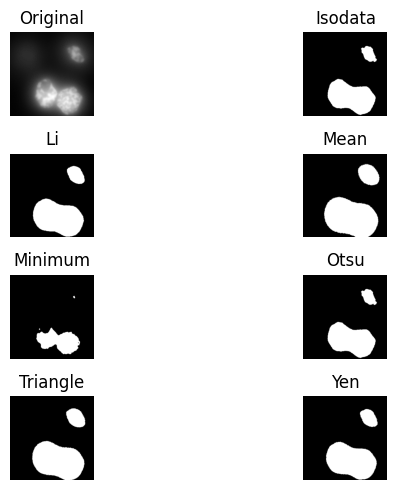

In [10]:
try_all_threshold(image[50,:,:])

From this we can choose a suitable threhold, in this case I picked otsu, but there's not much to choose between them. We can then import the specific threshold we'd like to use. You can see the function call for each method at the top of the output and they can be imported as shown here.

In [11]:
from skimage.filters.thresholding import threshold_otsu

The ```theshold_otsu``` function does not apply the threshold to the image. It calculates the value of the threshold.

In [12]:
thresh=threshold_otsu(image)
thresh

244

We can then create a binary image ```bw``` by comparing all the values in ```image``` to the threhold value.

In [13]:
bw = image > thresh
type(bw[0,0,0])

numpy.bool_

The elements of ```bw``` are of type bool. These elements are either ```True``` or ```False```. In this case they are ```True``` if the values are above the threshold value and ```False``` if they are below. Napari is able to visualise boolean images.

In [14]:
viewer = napari.view_image(bw)

The binary segmentation has done a fairly good job of finding the nuclei. However, the two that are close to one another have been joined together. As they are round objects, we can separate them using the ```watershed``` function from the ```skimage``` module ```segmentation```.

In [15]:
from skimage.segmentation import watershed

If we naively just try to apply the watershed function to our binary image, like we might do in 2D in Fiji, we get unsatisfactory results.

In [16]:
ws=watershed(bw)
viewer = napari.view_image(ws)

Checking the [watershed documentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) we can see that it uses ```local_minima``` by default. So let's try inverting the binary image with ```np.invert()``` so the nuclei will now be black and the background white. We also use the binary image (not inverted) to mask the result, so we only see the nuclei. 

In [17]:
ws=watershed(np.invert(bw),mask=bw)
viewer = napari.view_image(ws)

This is better. We can see the individual nuclei have been labelled with different intensity values, but the two joined cells have not been separated. Looking at the [watershed documentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.watershed) again, it advises that the markers for the watershed should be explicitaly defined. This means that we have to tell the watershed algorithm where the centres of our nuclei are.

For this we need to import more modules. Firstly, we need ```ndimage``` from the ```scipy``` package. ```scipy``` is installed with Napari. We will also use ```peak_local_max()``` to find local maxima in the image.

In [18]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

```ndimage``` contains a function to do a [Euclidean distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html) which measures the distance of the foreground of the image from the background. The ```peak_local_max()``` is used to find the points furthest from the backgroud, i.e. the centre of the nuclei. 

In [19]:
distance = ndi.distance_transform_edt(bw)

For the ```peak_local_max()``` function, the inputs are the distance transform. We can also give the minimum distance between peaks. Using napari we can estimate the size of the nuclei. Look in the bottom left corner of the napari viewer, while hovering the cursor over a point in the image. The coordinates shown here are the position of the cursor on the image. So by hovering the cursor over two points either side of the nuclei we can measure the diameter of a nuclei. Note that there are nuclei appear flattened so we should approximate x, y and z distance.

In [30]:
viewer = napari.view_image(bw)

The nuclei in the image have a major axis of approximately 50 pixels in x-y and a minor axis of approximately 15 pixels in z. ```peak_local_max()``` looks for peaks in regions of 2 * min_distance + 1 (* is multiplication in python). So as an estimate I assign the min_distance a value of 15.

In [34]:
peaks = peak_local_max(distance, min_distance=15)
peaks

array([[ 43, 194, 111],
       [ 48, 206, 182],
       [ 26,  71,  43],
       [ 65,  74, 206],
       [ 20,  72, 180]])

The coordinates of 5 peaks are outputted, this looks promising as there are 5 nuclei. Unfortunately, the ```watershed()``` function does not take coordinates as an input for the markers. We have to create a array the same size and shape of the images. All the values should be zero, except for the positions of the markers. These positions should each have a different integer value.

To do this in python, we can create an array of full of zeros using the ```np.zeros``` function. We can provide an ```array.shape``` ([remember from earlier?](#image.shape)) to give the dimensions, in this case it's the same as the distance image we created and we use dtype to say that all the values in this array should be integers.

The next tool we used is a for loop. This allows us to carry out a task for each item in a list or array. Here we want to say for each item in peaks, i.e. each set of coordinates, find the position in the zero array and replace the zero value with a different integer marker. This is what the code below does. The line ```for coords in peaks``` means assign the first set of coordinates in ```peaks``` to the variable ```coords```. The indented lines below tells python what do to with the ```coords```. This indent must be four spaces or a tab. Anything not indented is not part of the for loop. After carrying out the indented tasks, the next set of coordinates from ```peaks``` is assigned to the variable ```coords```. The tasks are then repeated with the next set of coordinates. This continues until all the coordinates in ```peaks``` have been used.

In the for loop below two tasks are completed. The first is to add 1 to the current value of ```i```. Before the loop ```i``` is defined as 0 and there are 5 sets of coordinates in ```peaks```, so ```i``` will take the value 1 for the first set of coordinates, 2 for the second etc. The second task takes the ```coords``` and transposes it ```coords.T``` and then converts the coords to a ```tuple()```. This has to be done so the correct element if the ```markers``` array is selected. It is then assigned the value ```i```. 

A tuple is a type of another type of data structure in python. We have already met arrays which are another. A tuple is an immutable and ordered data structure. This means that the contents cannot be changed once it has been created and neither can the order the elememts. This is important for images, if the elements of the nuclei image are rearranged we would no longer be able to visualise the shape of the nuclei. We have already seen a tuple earlier on in the notebook, can you think where?

In [22]:
markers = np.zeros(distance.shape, dtype=int)
i=0
for coords in peaks:
    i=i+1
    markers[tuple(coords.T)]=i

So now that the markers are defined, these can be passed to the watershed function resulting in the two nuclei now being labelled separately. Note that we need to give the watershed the negative distance map (i.e. distance from the markers).

In [23]:
ws=watershed(-distance,markers,mask=bw)
viewer = napari.view_image(ws)

Earlier we adjusted the settings in the napari viewer. Here is an example of defining the parameters as part of the script. The nuclei image is displayed as an isosurface and the labelled mask is coloured and displayed with an opacity of 0.5 so that we can see how well the segmentation has worked. Two image layers are used. The first is created with the ```napari.view_image``` function. This is used to define the viewer variable. ```viewer.add_image()``` is used to add another image to the same viewer. It is also possible to scale the data to physical dimensions rather than pixels and to add a scale bar. (The scales used here are not realistic or read from the metadata of the images, they are choosen to emphases the visual difference when viewed in napari)

In [36]:
viewer = napari.view_image(image,colormap='gray',name='image',rendering='iso', iso_threshold=11, scale=(0.5, 0.2, 0.2))
viewer.add_image(ws,colormap='turbo',name='mask',opacity=0.5, scale=(0.5, 0.2, 0.2))
viewer.scale_bar.visible = True
viewer.scale_bar.unit = "um"
napari.run()

Previously we used a for loop to format the markers array for the watershed function. If you have a lot of peaks this will be slow. It is better to define this array without a for loop. An example of how to do this is shown below. This is based on the [skimage watershed example](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py). 

In [25]:
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers2, _ = ndi.label(mask)
labels = watershed(-distance, markers2, mask=bw)

Try viewing the ```labels``` variable in napari along with watershed output ```ws``` to check they give the same result.

### Measurements

Now that we have completed the segmentation of the nuclei we may want to take some measurements. This can be done with ```skimage.measure.regionprops_table```. Read the [regionprops documentation](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops) to see the list of available properties that can be measured. It is also possible to define custom properties. As an example, here we measure the area of the nuclei and the mean intensity of the nuclei. The properties are defined using a list, a data structure that is mutable and ordered. The ```regionprops_table``` outputs a dictionary. This is data structure which is mutable and unorderd. Each of the elements in a dictionary is made up for a key-value pair. In this case the keys are the properties, area and intensity_mean, and the respective values are an array containing the measured values for each nuclei. In the output you can see the dictionary has curly brackets around it.

In [26]:
from skimage.measure import regionprops_table
properties = ['area', 'intensity_mean']
table = regionprops_table(ws, image, properties=properties)
table

{'area': array([202018., 164432., 160034., 141454.]),
 'intensity_mean': array([438.84981536, 438.50555853, 404.9145869 , 404.02810101])}

### Further Examples and Resources

#### Thresholding per plane for 2D+t time series using list comprehension.

In [27]:
thresh_per_plane = [threshold_otsu(image[t,:,:]) for t in range(image.shape[0])]
print(thresh_per_plane)

[60, 69, 79, 91, 105, 123, 143, 164, 181, 194, 203, 210, 216, 222, 228, 234, 240, 245, 250, 255, 259, 262, 264, 265, 266, 267, 267, 268, 268, 264, 260, 255, 255, 257, 260, 263, 266, 270, 275, 281, 288, 290, 293, 297, 300, 304, 309, 307, 303, 298, 291, 285, 281, 275, 269, 263, 256, 250, 245, 239, 235, 231, 227, 223, 221, 220, 229, 244, 251, 253, 253, 249, 244, 240, 236, 231, 223, 213, 199, 181, 159, 137, 116, 99, 86, 75, 67, 59, 53, 48, 43, 39, 35, 32, 30, 27, 25, 24, 23, 23]


This outputs a list of thresholds, one for each plane in an image stack. Note that since the order of the thresholds is important, it would be more suitable to create a tuple than a list. List comprehension a more consise way of writing for loops than in the example above. This is considered more "pythonic".

In [28]:
thresh_per_plane = tuple(threshold_otsu(image[t,:,:]) for t in range(image.shape[0]))
print(thresh_per_plane)

(60, 69, 79, 91, 105, 123, 143, 164, 181, 194, 203, 210, 216, 222, 228, 234, 240, 245, 250, 255, 259, 262, 264, 265, 266, 267, 267, 268, 268, 264, 260, 255, 255, 257, 260, 263, 266, 270, 275, 281, 288, 290, 293, 297, 300, 304, 309, 307, 303, 298, 291, 285, 281, 275, 269, 263, 256, 250, 245, 239, 235, 231, 227, 223, 221, 220, 229, 244, 251, 253, 253, 249, 244, 240, 236, 231, 223, 213, 199, 181, 159, 137, 116, 99, 86, 75, 67, 59, 53, 48, 43, 39, 35, 32, 30, 27, 25, 24, 23, 23)


#### Lazy loading using Dask
Example: https://napari.org/stable/tutorials/processing/dask.html \
My implementation: https://github.com/Laura190/sldyNapari \
Similar to virtual stacks in Fiji, it is possible to display images in napari without loading all the data into your RAM. It is also possible to define functions that are only executed when the images are viewed. In this example, images from light sheet data are deconvolved and deskewed on demand as the images are viewed.

#### Cellpose and reading metadata
My implementation: https://github.com/Laura190/NucleiSegmentationCellpose/blob/main/nuclei_segmentation.ipynb \
For the original challenge that this dataset was from I used (cellpose)[http://www.cellpose.org/] (some of the images were more challenging to segment than the one we used today). This script is an example of how to use batch processing with cellpose and uses napari to display the results.

#### Bioformats
It is possible to use bioformats in python. You need to install ```python-bioformats```. Then you can define a function like this:

```
import bioformats
import javabridge
import numpy as np

def open_image_stack(file_path):
    # Start the Java Virtual Machine
    javabridge.start_vm(class_path=bioformats.JARS)

    # Open the file
    with bioformats.ImageReader(file_path) as reader:
        # Read metadata
        size_z = reader.rdr.getSizeZ()
        size_c = reader.rdr.getSizeC()
        size_t = reader.rdr.getSizeT()
        size_x = reader.rdr.getSizeX()
        size_y = reader.rdr.getSizeY()

        # Read image stack
        image_stack = np.zeros((size_z, size_c, size_t, size_x, size_y), dtype=np.uint16)
        for t in range(size_t):
            for z in range(size_z):
                for c in range(size_c):
                    image_stack[z, c, t] = reader.read(c=c, z=z, t=t, series=None, rescale=False)

    # Stop the Java Virtual Machine
    javabridge.kill_vm()

    return image_stack
```
#### OMERO
For an example of reading data from OMERO into python see https://github.com/warwickcamdu/MinimalOmeropy

#### Skimage
For more examples of the available image processing tools as part of skimage see https://scikit-image.org/docs/stable/auto_examples/index.html

#### Napari
For more napari examples see https://napari.org/stable/tutorials/index.html

#### General Introductions to Python
Self guided beginners course: https://github.com/ChasNelson1990/python-zero-to-hero-beginners-course \
Training courses recommended by Warwick RSE: https://warwick.ac.uk/research/rtp/sc/rse/training/gettingstarted/